# Setup

In [1]:
#!pip install -q tensorflow

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Simulate synthetic longitudinal data

1000 patients, 4 vitals, 30 time points (20 are "the past", 10 are "the future")


In [2]:
n_patients = 1000
n_timesteps = 30
n_features = 4

np.random.seed(42)
data = np.random.randn(n_patients, n_timesteps, n_features) + np.linspace(0, 5, n_timesteps).reshape(1, -1, 1)

input_seq_len = 20
forecast_horizon = 10

X = data[:, :input_seq_len, :]
y = data[:, input_seq_len:input_seq_len+forecast_horizon, :]

In [3]:
# Just reporting the shapes, to be sure about what's happening
print("X.shape" + str(X.shape))
print("y.shape" + str(y.shape))

X.shape(1000, 20, 4)
y.shape(1000, 10, 4)


# Train/Val split

In [4]:
split = int(n_patients * 0.8)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

# Support functions

## Positional encoding


Transformers don't have, per se, a notion of order (before/after) so all inputs come at the same time.

We encode the order with a special ad hoc function, which copies the original sinusoidal encoding from the famous [Attention is all you need](https://arxiv.org/abs/1706.03762) paper. It uses sinusoidal functions with different frequencies to encode the position of each element in a sequence.

For even (2i) locations, you the formula is:

```
                          pos
PE(pos, 2i) = sin(---------------------)
                   10000 ^ (2i / depth)
```

For odd (2i+1) locations, you the formula is:

```
                            pos
PE(pos, 2i+1) = cos(---------------------)
                     10000 ^ (2i / depth)
```

For more info on positional encoding refer to [this entry](https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/)

In [5]:
# Positional Encoding for Transformers
# arguments:
# - length: the number of time steps (sequence length)
# - depth: the dimensionality of the embedding (e.g., 64, 128)
def positional_encoding(length, depth):
    depth = int(depth / 2)                           # half positions are sin-based, half cos-based
    positions = np.arange(length)[:, np.newaxis]     # shape: (length, 1) content: 0, 1, 2, ... , length-1
    depths = np.arange(depth)[np.newaxis, :] / depth # shape: (1, depth)  content: fractions from zero to 1

    # Each position and depth combination gets a unique frequency
    # These frequencies span a log scale, ensuring each dimension
    # encodes a different granularity of position
    angle_rates = 1 / (10000**depths)                # shape: (1, depth)
    angle_rads = positions * angle_rates             # shape: (pos, depth)

    # Computing the actual encoding, alternating sin and cos
    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)], axis=-1
    )

    # Returning a tensor (in float 32 precision) ready to be put into
    # the architecture
    return tf.cast(pos_encoding, dtype=tf.float32)

In [6]:
# Let's try it
print(positional_encoding(length=10, depth=4))

tf.Tensor(
[[ 0.          0.          1.          1.        ]
 [ 0.84147096  0.00999983  0.5403023   0.99995   ]
 [ 0.9092974   0.01999867 -0.41614684  0.9998    ]
 [ 0.14112     0.0299955  -0.9899925   0.99955004]
 [-0.7568025   0.03998933 -0.6536436   0.9992001 ]
 [-0.9589243   0.04997917  0.2836622   0.99875027]
 [-0.2794155   0.059964    0.96017027  0.99820054]
 [ 0.6569866   0.06994285  0.75390226  0.997551  ]
 [ 0.98935825  0.0799147  -0.14550003  0.99680173]
 [ 0.4121185   0.08987855 -0.91113025  0.9959527 ]], shape=(10, 4), dtype=float32)


## Actual architecture

We define two functions:

* `build_model()` it's the general function that instantiate the full architecture, from input to output. Internally it uses also the following
* `transformer_encoder()` the actual transformer block, with multihead attetion and normalization

In [7]:

# Transformer block, straight out of "Attention is all you need"
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)

    x_ff = layers.Dense(ff_dim, activation="relu")(x)
    x_ff = layers.Dense(inputs.shape[-1])(x_ff)
    x = layers.LayerNormalization(epsilon=1e-6)(x + x_ff)
    return x

# Build Transformer model for forecasting
def build_model(input_shape, forecast_len):

    # Input layer, which receives the input data
    inputs = keras.Input(shape=input_shape)

    # Adding the positional encoding to the current input
    x = inputs + positional_encoding(input_shape[0], input_shape[1])

    # Adding two transformer blocks
    x = transformer_encoder(x, head_size=64, num_heads=2, ff_dim=128, dropout=0.1)
    x = transformer_encoder(x, head_size=64, num_heads=2, ff_dim=128, dropout=0.1)

    # Collapse the sequence dimension using global average pooling
    # shape goes from (batch, time, features) to (batch, features)
    x = layers.GlobalAveragePooling1D()(x)

    # Getting ready for doing a forecas via a dense layer, plus a reshaping
    # so that it matches the expected output
    x = layers.Dense(forecast_len * input_shape[1])(x)
    outputs = layers.Reshape((forecast_len, input_shape[1]))(x)

    # Done. Let's just build a model out of it so it's trainable
    return keras.Model(inputs, outputs)

The model will have this interface:

* Input: (batch_size, seq_len, features)
* Output: same shape



# Setup model, train

In [8]:
model = build_model(X_train.shape[1:], forecast_horizon)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 20, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 20, 4)     │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 4)     │      2,436 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 20, 4)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 20, 4)     │          0 │ dropout_1[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 20, 4)     │          8 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 20, 128)   │        640 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 20, 4)     │        516 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 20, 4)     │          0 │ layer_normalizat… │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 4)     │          8 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 4)     │      2,436 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 20, 4)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 20, 4)     │          0 │ dropout_3[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 4)     │          8 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 20, 128)   │        640 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 20, 4)     │        516 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 20, 4)     │          0 │ layer_normalizat… │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 4)     │          8 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 4)         │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                 

 Total params: 7,416 (28.97 KB)

 Trainable params: 7,416 (28.97 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Training the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=32
)

Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 17.6727 - mae: 4.0403 - val_loss: 16.5472 - val_mae: 3.8936
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 16.1146 - mae: 3.8350 - val_loss: 15.3508 - val_mae: 3.7345
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 14.9709 - mae: 3.6811 - val_loss: 14.1151 - val_mae: 3.5628
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 13.8143 - mae: 3.5174 - val_loss: 12.8494 - val_mae: 3.3779
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 12.4585 - mae: 3.3174 - val_loss: 11.5748 - val_mae: 3.1815
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 11.2118 - mae: 3.1235 - val_loss: 10.3104 - val_mae: 2.9753
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 10.0148 - mae: 2.9211 - val_loss: 9.0817 - val_mae: 2.7619
Epoch 8/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 8.7692 - mae: 2.7069 - val_loss: 7.9118 - val_mae: 2.5452
Epoch 9/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step 

# Explore results

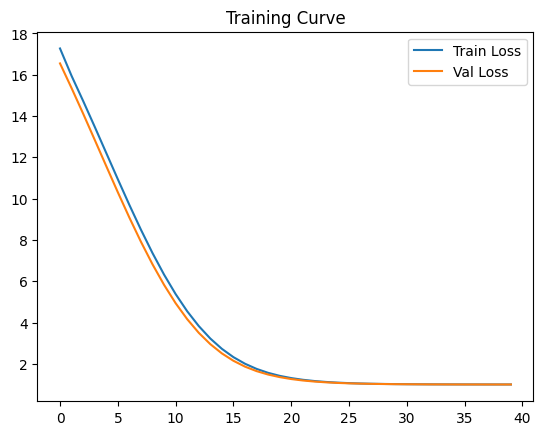

In [10]:
# Plot results
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Training Curve")
plt.show()

# Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


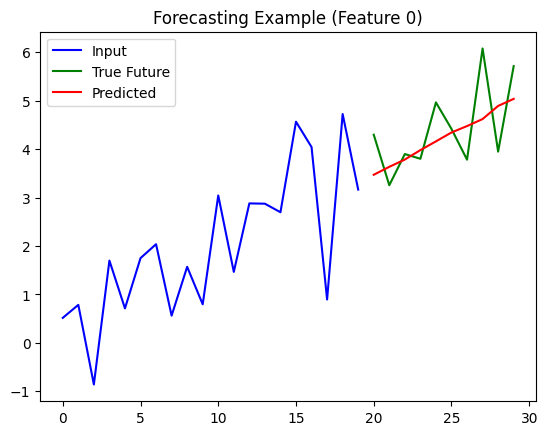

In [11]:
# Make predictions on the first patient of the validation set
sample_input = X_val[0:1]
prediction = model.predict(sample_input)

# Plotting past (training data) and future (truth and predictions) for
# the first feature (out of four)
plt.plot(range(input_seq_len), sample_input[0,:,0], label="Input", color="blue")
plt.plot(range(input_seq_len, input_seq_len + forecast_horizon), y_val[0,:,0], label="True Future", color="green")
plt.plot(range(input_seq_len, input_seq_len + forecast_horizon), prediction[0,:,0], label="Predicted", color="red")
plt.legend()
plt.title("Forecasting Example (Feature 0)")
plt.show()